In [2]:
COLAB = True

if COLAB: 
  from google.colab import drive
  drive.mount('/content/drive/')
  !unzip src.zip
  !mkdir data && mkdir data/models
  speech_path, save_path = "drive/MyDrive/audio-pattern", "drive/MyDrive/audio-pattern"
else:
  speech_path, save_path = "data/raw/speech", "data/processed"

Mounted at /content/drive/
Archive:  src.zip
   creating: src/
 extracting: src/__init__.py         
  inflating: src/data_processing.py  
  inflating: src/loader.py           
  inflating: src/dataset.py          
  inflating: src/utility.py          
  inflating: src/models.py           


In [13]:
from src.data_processing import FeatureExtractor
from src.dataset import Dataset
from src.loader import Loader
from src.models import build_train_simple, train_nn, build_nn, build_cnn, build_lstm

import seaborn as sns
sns.set_theme()

import numpy as np
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(1)

import warnings  
warnings.filterwarnings("ignore")

# Loading data

In [4]:
loader = Loader(speech_path, save_path, True, 0, -1)
data, labels = loader.load(False)

In [5]:
from src.data_processing import identity
ext_features, ext_labels = FeatureExtractor(raw_data=data, labels=labels, 
                                            save_path=f"{save_path}/features", 
                                            file_name="full",
                                            augmenter=identity, 
                                            verbose=True, 
                                            only_mfcc=False).get_training_data(overwrite=False)

Filename: full found on disk



# Models training

### SVM, K-NN, Decision Tree

In [6]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as Dtree

d = Dataset(original_data=(ext_features, ext_labels), augmented_data=[])
X_train, X_test, y_train, y_test = d.get_training_data(label="emotion", train_perc=0.7)

k = int(len(X_train)**0.5)
scores = []
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), SVC()))
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), KNN(k)))
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), Dtree(max_depth=10)))

In [7]:
print("Simple models scores on test:\n")
print("\n".join([f"\t- {a:5} : {b:0.3f}" for a, b in zip(["Svc", "Knn", "Dtree"], scores)]))

Simple models scores on test:

	- Svc   : 0.598
	- Knn   : 0.459
	- Dtree : 0.393


### MLP, CNN, LSTM

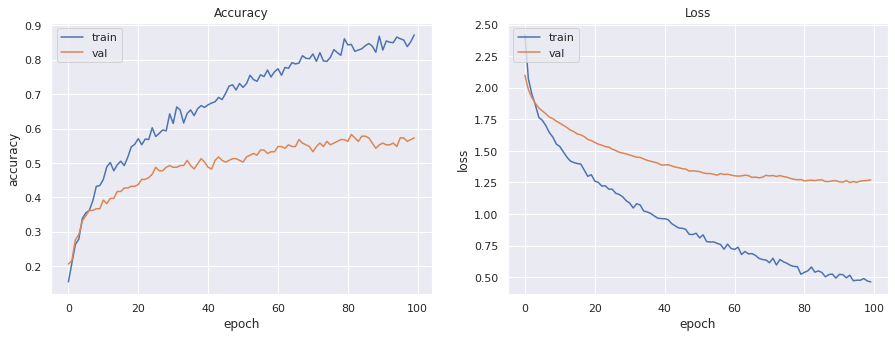

In [8]:
nn_scores = []
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_nn, epochs=100, verbose=0, plot=True)[1])

In [9]:
# extract only mfcc for cnn and lstm
mfcc_features, mfcc_labels = FeatureExtractor(raw_data=data, labels=labels, 
                                            save_path=f"{save_path}/features", 
                                            file_name="mfcc",
                                            augmenter=identity, 
                                            verbose=True, 
                                            only_mfcc=True).get_training_data(overwrite=False)
mfcc_features = np.expand_dims(mfcc_features, axis=2)

Filename: mfcc found on disk



In [10]:
d = Dataset(original_data=(mfcc_features, mfcc_labels), augmented_data=[])
X_train, X_test, y_train, y_test = d.get_training_data(label="emotion", train_perc=0.7)

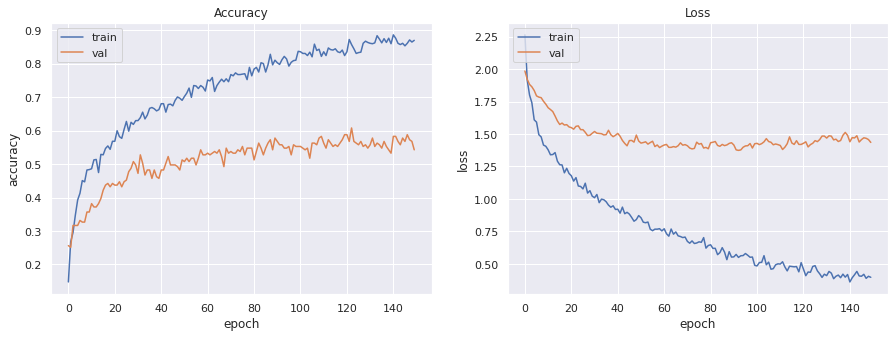

In [11]:
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_cnn, epochs=150, verbose=0, plot=True)[1])

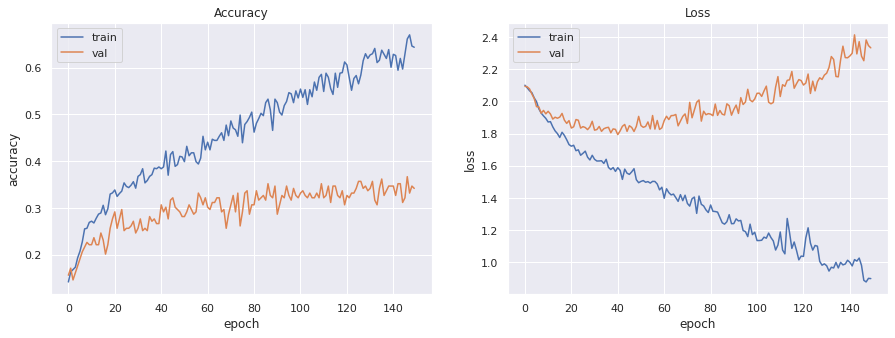

In [14]:
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_lstm, epochs=150, verbose=0, plot=True)[1])

In [15]:
print("Neural networks scores on test:\n")
print("\n".join([f"\t- {a:5} : {b:0.3f}" for a, b in zip(["MLP", "CNN", "LSTM"], nn_scores)]))

Neural networks scores on test:

	- MLP   : 0.609
	- CNN   : 0.605
	- LSTM  : 0.409
